The measurement of the muon transverse momentum of muons is sensitive to several detector conditions:
   * the *alignment* of the tracker and of the muon chambers
   * the *composition and distribution of the material* inside the tracking volume
   * the knowledge of the *magnetic field* inside and outside the solenoid volume.
<br>

All these conditions affect differently the momentum measurement and can produce biases. In particular, the detector misalignment produces a relative bias that generally increases linearly with the momentum. For this reason it is extremely important to have an accurate knowledge of the tracker and muon spectrometer alignment, and a detailed mapping of the detector material and of the magnetic field. Residual biases can be corrected *a posteriori*, using calibration techniques that generally exploit data from very well-known processes, such as J/&psi;&rarr;&mu;&mu; or Z&rarr;&mu;&mu; decays.

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot_methods
import ROOT
import roccor

In [4]:
a=roccor.RoccoR("2016.txt")

In [6]:
#events=uproot.open('/cms/store/user/hats/Muon/DYJetsToMuMu_M-50_TuneCP5_13TeV-madgraphMLM-pythia8.root')['Events']
file=uproot.open('~/Downloads/DYJetsToMuMu_M-50_TuneCP5_13TeV-madgraphMLM-pythia8.root')['Events']

In [163]:
muon=ak.JaggedArray.zip(muon_pt=file.array('Muon_pt'), muon_eta= file.array('Muon_eta'), muon_phi= file.array('Muon_phi'),
                        muon_isglobal= file.array('Muon_isGlobal'), muon_istracker= file.array('Muon_isTracker'),
                        muon_mass= file.array('Muon_mass'),
                        muon_charge= file.array('Muon_charge'),
                        muon_pfreliso03_chg= file.array('Muon_pfRelIso03_chg'),
                        muon_genpartidx= file.array('Muon_genPartIdx'),
                        muon_ntrackerlayers= file.array(['Muon_nTrackerLayers']),
                        genpart_pt= file.array('GenPart_pt')[file.array('Muon_genPartIdx')],
                        genpart_eta= file.array('GenPart_eta')[file.array('Muon_genPartIdx')],
                        genpart_phi= file.array('GenPart_phi')[file.array('Muon_genPartIdx')],
                        genpart_mass= file.array('GenPart_mass')[file.array('Muon_genPartIdx')],
                        genpart_pdgid= file.array('GenPart_pdgId')[file.array('Muon_genPartIdx')],
                        genpart_status= file.array('GenPart_status')[file.array('Muon_genPartIdx')],
                        genpart_statusFlags= file.array('GenPart_statusFlags')[file.array('Muon_genPartIdx')],
                        )

# Step 1: Generated and reconstructed dimuon Z mass
First, lets reconstruct dimuon z mass.
reapplying previous code. Using the following criteria to select two well-defined and isolated muons. For instance, you can require that both muons pass:<br>

* Muon_genPartIdx!=-1(each muon must have an associated generated particle)
* Muon_isGlobal==1
* Muon_pt>20.
* abs(Muon_eta)<2.4
* Muon_pfRelIso03_chg<0.15

In [124]:
muon_mask=(muon.genpart_pdgid!=-1)& (muon.muon_isglobal==1)& (muon.muon_pt>20)& (abs(muon.muon_eta)<2.4)& (muon.muon_pfreliso03_chg<0.15)

In [125]:
muons_good=muon[muon_mask]

In [126]:
(muon_mask.sum()==2).sum()

125698

In [127]:
(muon_mask.sum()==3).sum()

96

In [128]:
(muon_mask.sum()==1).sum()

94840

Note here if we write a for loop, then 94840 events are don't woth to loop over it. By using columnar method, they can be skipped

In [129]:
(muon_mask.sum()==4).sum()

0

In [130]:
(muon_mask.sum()==5).sum()

0

In [131]:
(muon_mask.sum()==6).sum()

0

We only keep events with 2 good muons. There are 6 events with over 2 muons, we will ignore them for simplicity.

In [132]:
two_good_muons=muons_good[muon_mask.sum()==2]

In [133]:
two_good_muons.muon_charge

<JaggedArray [[-1 1] [1 -1] [1 -1] ... [-1 1] [1 -1] [1 -1]] at 0x7fb539e63ed0>

Lets make sure muons in eaach events have opposite charge

In [134]:
opposite_sign_muon_mask=(two_good_muons.muon_charge[:,0]!=two_good_muons.muon_charge[:,1])

In [135]:
two_opposite_good_muons=two_good_muons[opposite_sign_muon_mask]
opposite_sign_muon_mask.sum()

125648

In [136]:
two_muon_p4=uproot_methods.TLorentzVectorArray.from_ptetaphim(two_opposite_good_muons.muon_pt, two_opposite_good_muons.muon_eta,
                                                              two_opposite_good_muons.muon_phi, two_opposite_good_muons.muon_mass)

In [137]:
dimuon_p4=two_muon_p4[:,0]+two_muon_p4[:,1]
#dimuon_p4.mass

We can further restrict the selection by requiring the invariant mass is between 70 and 110 GeV

In [138]:
dimuon_mass_mask=(dimuon_p4.mass>70)&(dimuon_p4.mass<110)

Text(0, 0.5, 'Events')

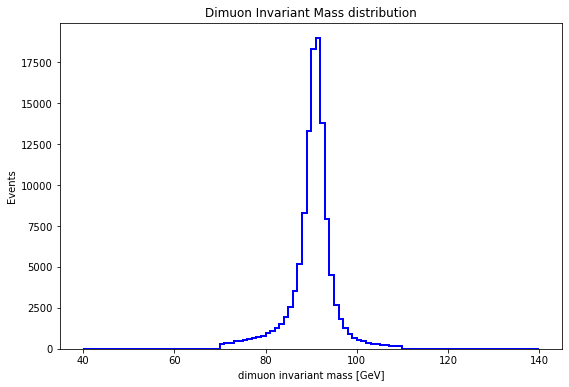

In [139]:
plt.figure(figsize=(9,6))
plt.hist(dimuon_p4.mass[dimuon_mass_mask], bins=100, range=[40,140], histtype='step',linewidth=2, color='blue', label='dimuon invariant mass')
plt.title('Dimuon Invariant Mass distribution')
plt.xlabel('dimuon invariant mass [GeV]')
plt.ylabel('Events')

Now lets get their corresponding genpart and gen dimuon mass.

In [140]:
two_gen_muon_p4=uproot_methods.TLorentzVectorArray.from_ptetaphim(two_opposite_good_muons.genpart_pt, two_opposite_good_muons.genpart_eta,
                                                                  two_opposite_good_muons.genpart_phi, two_opposite_good_muons.genpart_mass)

In [141]:
gen_dimuon_p4=two_gen_muon_p4[:,0]+two_gen_muon_p4[:,1]

/Users/tarantula/miniconda3/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


Text(0, 0.5, 'Events')

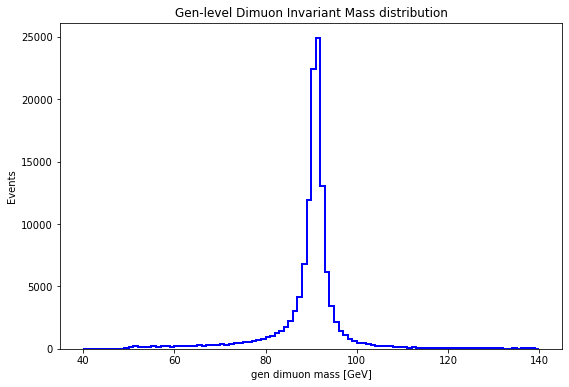

In [142]:
plt.figure(figsize=(9,6))
plt.hist(gen_dimuon_p4.mass, bins=100, range=[40,140], histtype='step', linewidth=2, color='blue', label='gen dimuon_mass')
#plt.legend()
plt.title('Gen-level Dimuon Invariant Mass distribution')
plt.xlabel('gen dimuon mass [GeV]')
plt.ylabel('Events')

Then, we fit both generated and reconstructed Z mass.<br>
Keep in mind that the Z line shape is not Gaussian, so the Gaussian fit might not be perfect. We then fit them with more suitable functions for each case, e.g. a Breit-Wigner function for the generated mass and a Voigt function (i.e. a convolution of a Breit-Wigner with a Gaussian) for the reconstructed mass. You can easily do this from the ROOT e.g.:

 FCN=493.536 FROM MIGRAD    STATUS=CONVERGED     191 CALLS         192 TOTAL
                     EDM=1.33961e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.89810e+04   1.98908e+02   2.04859e+00   2.65621e-09
   2  p1           9.10301e+01   5.79735e-03   6.23834e-05  -7.17895e-04
   3  p2           2.77742e+00   1.49030e-02   1.52317e-04   1.58602e-04


Warning in <TROOT::Append>: Replacing existing TH1: h_GenDiMuonM (Potential memory leak).


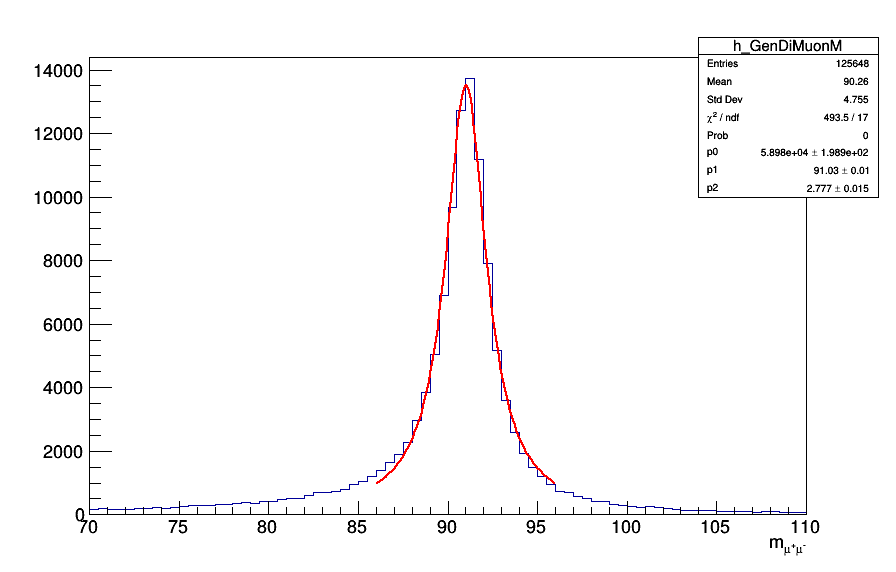

In [143]:
c1 = ROOT.TCanvas("gendimuonmass","",900,600)
h_GenDiMuonM = ROOT.TH1F("h_GenDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in gen_dimuon_p4.mass:
    h_GenDiMuonM.Fill(m)
h_GenDiMuonM.Draw()
c1.Draw()
f2 = ROOT.TF1("f2", "[0]*TMath::BreitWigner(x, [1], [2])", 86., 96.)
f2.SetParameter(1, 91.1876)
f2.SetParameter(2, 2.4952)
h_GenDiMuonM.Fit("f2", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c1.Draw()

 FCN=182.13 FROM MIGRAD    STATUS=CONVERGED     314 CALLS         315 TOTAL
                     EDM=1.05901e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.6 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.08414e+04   3.11142e+02   3.86580e-01  -1.45785e-07
   2  p1           9.09627e+01   8.23348e-03   3.84209e-06   6.48443e-04
   3  p2           8.31528e-01   4.12141e-02  -6.00795e-05   3.62415e-03
   4  p3           3.31310e+00   6.21676e-02   1.05607e-04   2.52001e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: recdimuonmass
Warning in <TROOT::Append>: Replacing existing TH1: h_RecDiMuonM (Potential memory leak).


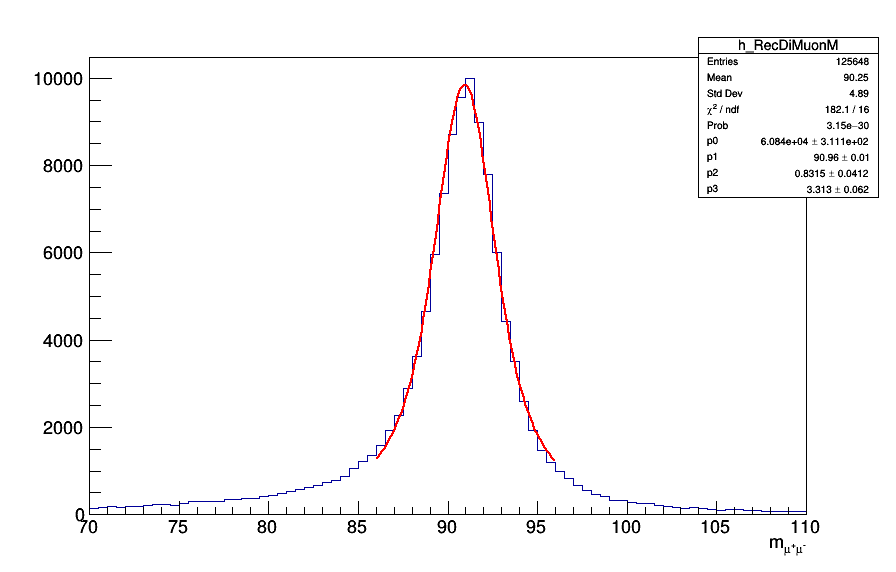

In [144]:
c2 = ROOT.TCanvas("recdimuonmass","",900,600)
h_RecDiMuonM = ROOT.TH1F("h_RecDiMuonM",";m_{#mu^{+}#mu^{-}};",80,70,110)
for m in dimuon_p4.mass:
    h_RecDiMuonM.Fill(m)
h_RecDiMuonM.Draw()
c2.Draw()
f1 = ROOT.TF1("f1", "[0]*TMath::Voigt(x-[1], [2], [3])", 86., 96.)
f1.SetParameter(1, 91.1876)
f1.SetParameter(3, 2.4952)
h_RecDiMuonM.Fit("f1", "", "", 86., 96.)
ROOT.gStyle.SetOptFit(1111)
c2.Draw()
#h_RecDiMuonM.Fit("gaus","","", 86., 96.)

**Questions 1:**
   * Compare the mean values obtained from the fits to the generated and reconstructed distributions. Are they compatible or do they differ significantly? How do they compare to the nominal Z mass value, m<sub>Z</sub> = 91.1876 GeV? Which distribution has the larger shift with respect to m<sub>Z</sub>?
   * Compare the widths of the two distributions (GEN and RECO). Which one is larger? Can you explain why? 
   * Considering that the natural width of the Z boson is &Gamma;<sub>Z</sub> = 2.4952 GeV, can you roughly estimate the typical dimuon mass resolution of Z&rarr;&mu;&mu; events measured with the CMS detector?(*Note:* with a _Voigtian_ fit, you would get an estimate of the  mass resolution directly from the fit) 
   * Why do you need different functions to better fit the generated and reconstructed mass distributions? What differs between the two? If you had to fit the peak of a reconstructed J/&psi; instead, what function would you use, and why?



Answer:
1. Depend on the dataset
1. See hist
1. J/ψ has much small width, so gussian should be used

# Step 2: Investigate the shape of the dimuon mass spectrum
Next, we will create [TProfile histograms](http://root.cern.ch/root/html/TProfile.html) of the reconstructed dimuon invariant mass _vs_ azimuthal coordinate of the muon direction (&phi;), separately for positive and negative muons, as well as the dimuon mass _vs_ pseudorapidity (&eta;) of the muon. E.g.:

In [145]:
prof_MuPlusPhiVsDiMuonM=ROOT.TProfile("prof_MuPlusPhivsDiMuonM","#mu^{+} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(+) #phi[rad]; Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuPlusPhivsDiMuonM (Potential memory leak).


In [146]:
mup_phi=two_opposite_good_muons.muon_phi[two_opposite_good_muons.muon_charge>0].flatten()

In [147]:
for phi, m in zip(mup_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuPlusPhiVsDiMuonM.Fill(phi, m, 1)

In [148]:
c3 = ROOT.TCanvas("mupphidimum","",900,600)
prof_MuPlusPhiVsDiMuonM.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: mupphidimum


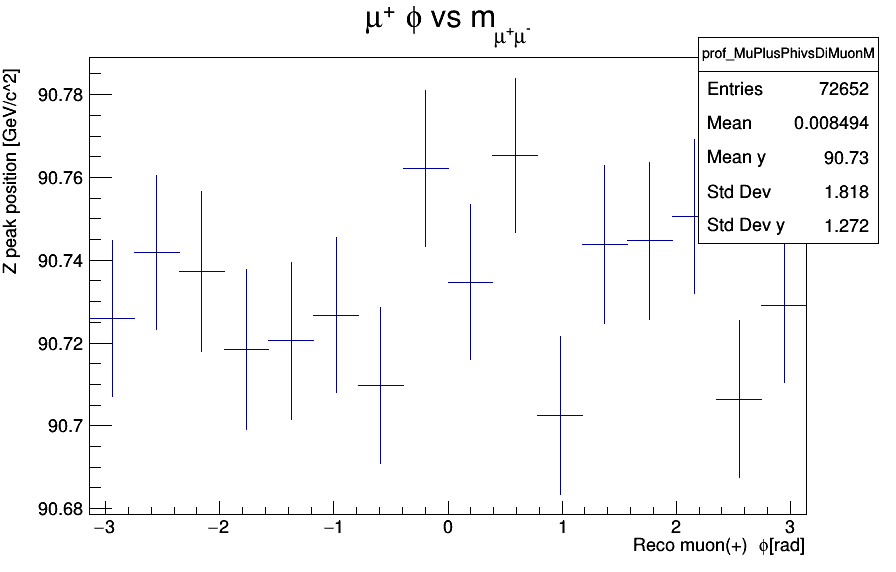

In [149]:
c3.Draw()

In [150]:
mum_phi=two_opposite_good_muons.muon_phi[two_opposite_good_muons.muon_charge<0].flatten()
prof_MuMinusPhivsDiMuonM = ROOT.TProfile("prof_MuMinusPhivsDiMuonM","#mu^{-} #phi vs m_{#mu^{+}#mu^{-}};Reco muon(-) #phi[rad];Z peak position [GeV/c^2]",16,-3.14,3.14,88,93)

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuMinusPhivsDiMuonM (Potential memory leak).


In [151]:
for phi, m in zip(mum_phi[dimuon_mass_mask], (dimuon_p4.mass)[dimuon_mass_mask]):
   prof_MuMinusPhivsDiMuonM.Fill(phi, m, 1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: mumphidimum


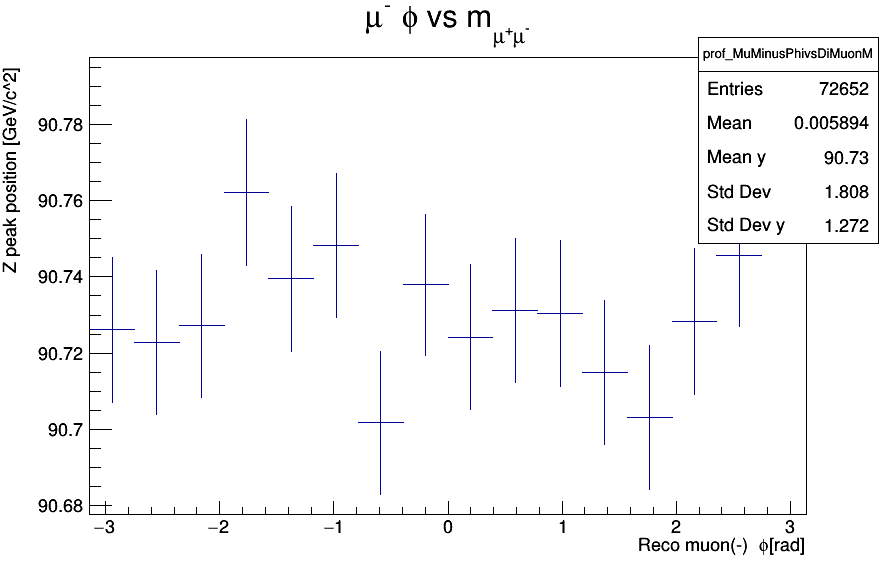

In [152]:
c2 = ROOT.TCanvas("mumphidimum","",900,600)
prof_MuMinusPhivsDiMuonM.Draw()
c2.Draw()

In [153]:
prof_MuEtavsDiMuonM = ROOT.TProfile("prof_MuEtavsDiMuonM","Muon #eta vs m_{#mu^{+}#mu^{-}};Reco Muon #eta; Z peak position [GeV/c^2]",50,-2.4,2.4,88,93)

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuEtavsDiMuonM (Potential memory leak).


In [154]:
for eta1, eta2, m in zip(two_opposite_good_muons[dimuon_mass_mask].muon_eta[:,0],
                         two_opposite_good_muons[dimuon_mass_mask].muon_eta[:,0],
                         dimuon_p4.mass[dimuon_mass_mask]):
    prof_MuEtavsDiMuonM.Fill(eta1, m, 1)
    prof_MuEtavsDiMuonM.Fill(eta2, m, 1)
    

Warning in <TCanvas::Constructor>: Deleting canvas with same name: muetadimum


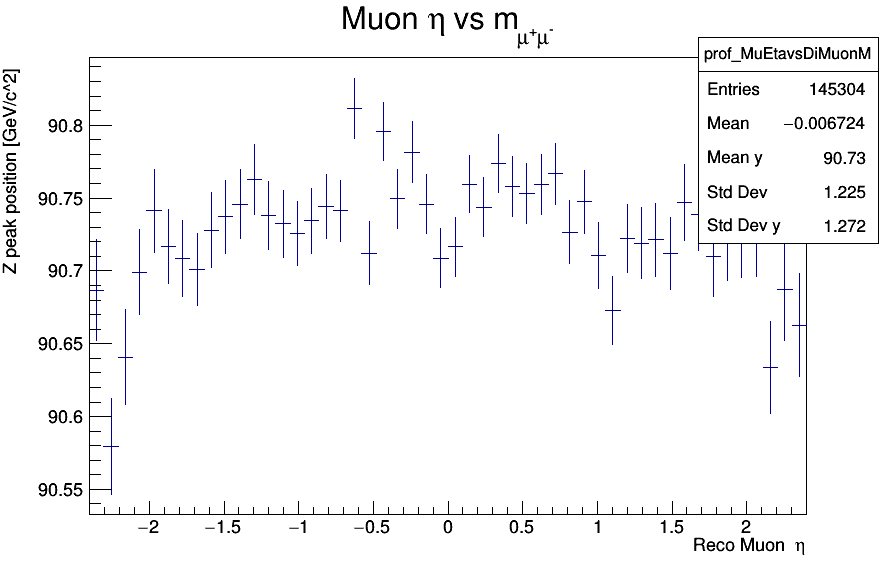

In [155]:
c4 = ROOT.TCanvas("muetadimum","",900,600)
prof_MuEtavsDiMuonM.Draw()
c4.Draw()

**Questions 2:**
   * What do they look like? Is the reconstructed mass flat _vs_ &phi; and &eta; or are there deviations? 
   * Are the deviations compatible with statistical fluctuations or do you notice a trend? 
   * What could explain this behavior?


Answer:
The high eta region, the rate is highest, reducing resolution.

# Step 3: Investigate the muon transverse momentum resolution

Now we will study the muon transverse momentum resolution. We will consider distributions of the transverse momentum residuals, defined as  R(1/pT) = (1/pT<sup>REC</sup> &ndash; 1/pT<sup>GEN</sup>)/(1/pT<sup>GEN</sup>). In the ideal case, the distribution of the residuals is expected to be Gaussian and its standard deviation is the pT resolution. Likewise, we can define the dimuon invariant mass residuals as R(M) = (M<sup>REC</sup> &ndash; M<sup>GEN</sup>)/M<sup>GEN</sup>, and the standard deviation of the R(M) distribution defines the mass resolution. 

We will create the following histograms:
   * 1D histogram of the muon transverse momentum residuals R(1/PT): A histogram (h_MupTRes) of the muon transverse momentum residual using the PAT muons and GEN muons. Fit this distribution to a Gaussian function. The fit parameter sigma gives the muon transverse momentum resolution in the chosen p<sub>T</sub> range.
   * 1D histogram of the dimuon invariant mass residuals R(M): A histogram (h_MassRes) for the invariant mass resolution residual, which is defined as (M<sub>rec</sub> - M<sub>gen</sub> )/M<sub>gen</sub>. Fit this distribution to a Gaussian.
   * Profile histograms (prof_MupTvspTRes and prof_MuEtavspTRes) of muon transverse momentum residuals  as a function of muon pT and &eta;.
Note that, by default, a [TProfile](http://root.cern.ch/root/html/TProfile.html) will display in each bin the <span style='color:red'> mean value $\pm$ mean value error </span> (i.e. RMS/$\sqrt(N)$). Initializing the [TProfile](http://root.cern.ch/root/html/TProfile.html)  with option "s" instead, it will display <span style='color:red'> mean value $\pm$ RMS </span>. This is more useful for us, as the RMS estimates the standard deviation, i.e. the resolution of each bin. 

Text(0, 0.5, 'Events')

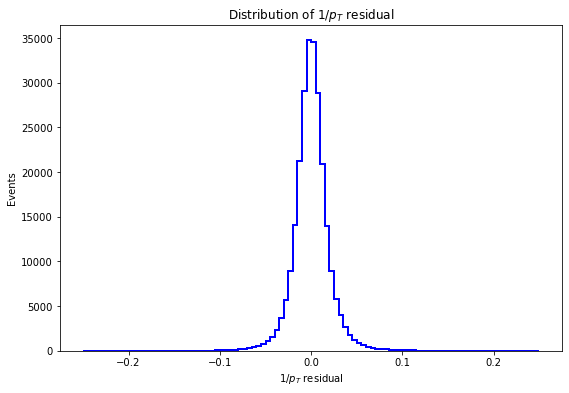

In [156]:
pt_res=two_opposite_good_muons.genpart_pt.flatten()/two_opposite_good_muons.muon_pt.flatten()-1
plt.figure(figsize=(9,6))
plt.hist(pt_res, bins=100, range=[-0.25,0.25], histtype='step',linewidth=2, color='blue', label='$1/p_T$ residual')
#plt.legend()
plt.title('Distribution of $1/p_T$ residual')
plt.xlabel('$1/p_T$ residual')
plt.ylabel('Events')

In [157]:
mass_res=dimuon_p4.mass.flatten()/gen_dimuon_p4.mass.flatten()-1

/Users/tarantula/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Events')

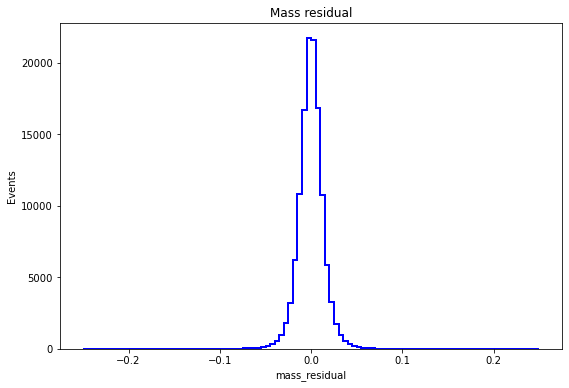

In [158]:
plt.figure(figsize=(9,6))
plt.hist(mass_res, bins=100, range=[-0.25,0.25], histtype='step', linewidth=2, color='blue', label='mass_residual')
#plt.legend()
plt.title('Mass residual')
plt.xlabel('mass_residual')
plt.ylabel('Events')

 FCN=11639.6 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=3.259e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.06099e+04   8.97542e+01   3.29542e+00  -3.16881e-07
   2  Mean         3.77339e-05   3.19145e-05   1.68011e-06   7.95193e+00
   3  Sigma        1.56050e-02   3.28051e-05   2.26351e-05  -1.38664e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: ptresidual
Warning in <TROOT::Append>: Replacing existing TH1: h_MupTRes (Potential memory leak).
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error i

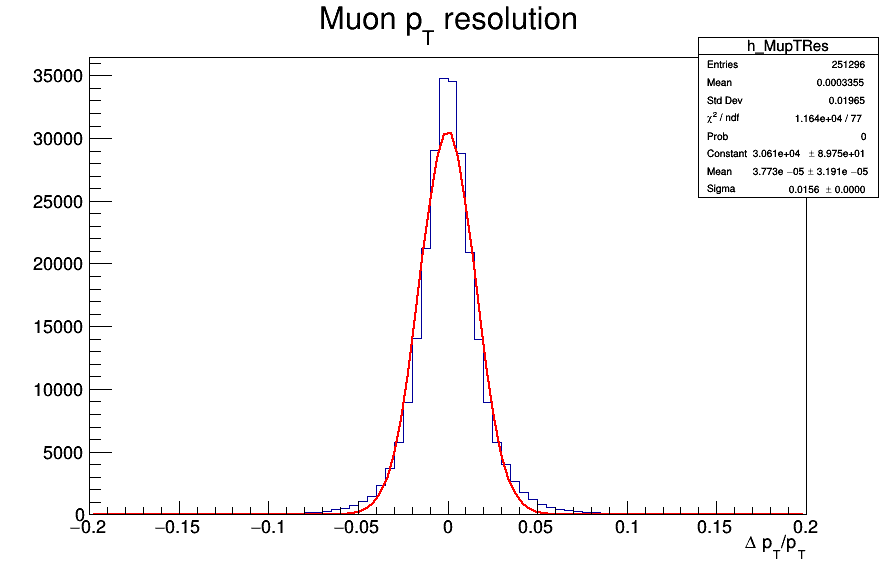

In [159]:
c4 = ROOT.TCanvas("ptresidual","",900,600)
h_MupTRes = ROOT.TH1F("h_MupTRes","Muon p_{T} resolution;#Delta p_{T}/p_{T};",80,-0.2,0.2)
for res in pt_res:
    h_MupTRes.Fill(res)
h_MupTRes.Draw()
c4.Draw()
h_MupTRes.Fit("gaus")

 FCN=3762.02 FROM MIGRAD    STATUS=CONVERGED      66 CALLS          67 TOTAL
                     EDM=6.52506e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.51320e+04   5.99186e+01   1.29890e+00  -1.08571e-06
   2  Mean        -8.32128e-05   3.44982e-05   1.03331e-06   3.97509e+00
   3  Sigma        1.20376e-02   3.28851e-05   1.80645e-05  -4.50238e-01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: massresidual
Warning in <TROOT::Append>: Replacing existing TH1: h_MassRes (Potential memory leak).
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error

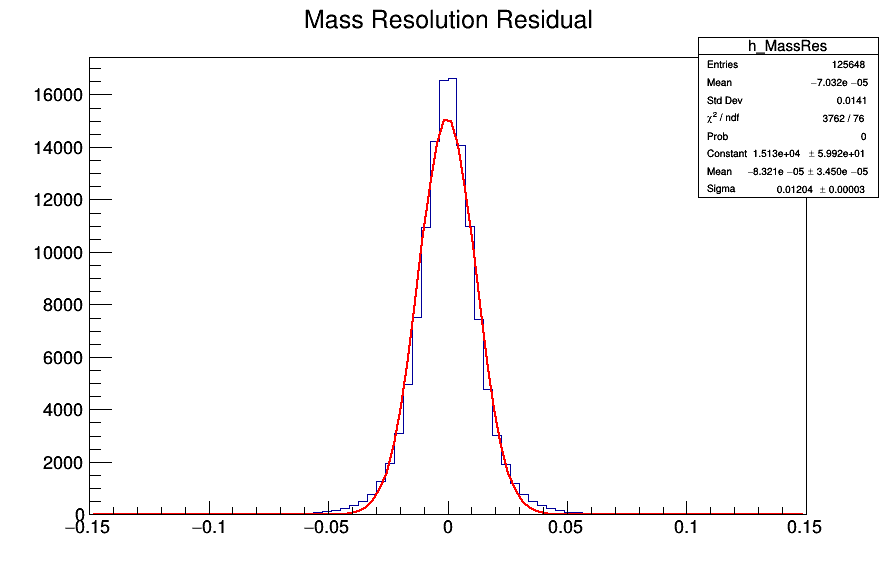

In [160]:
c6 = ROOT.TCanvas("massresidual","",900,600)
h_MassRes = ROOT.TH1F("h_MassRes","Mass Resolution Residual",80,-0.15,0.15)
for res in mass_res:
    h_MassRes.Fill(res)
h_MassRes.Draw()
c6.Draw()
h_MassRes.Fit("gaus")

Warning in <TROOT::Append>: Replacing existing TH1: prof_MuEtavspTRes (Potential memory leak).


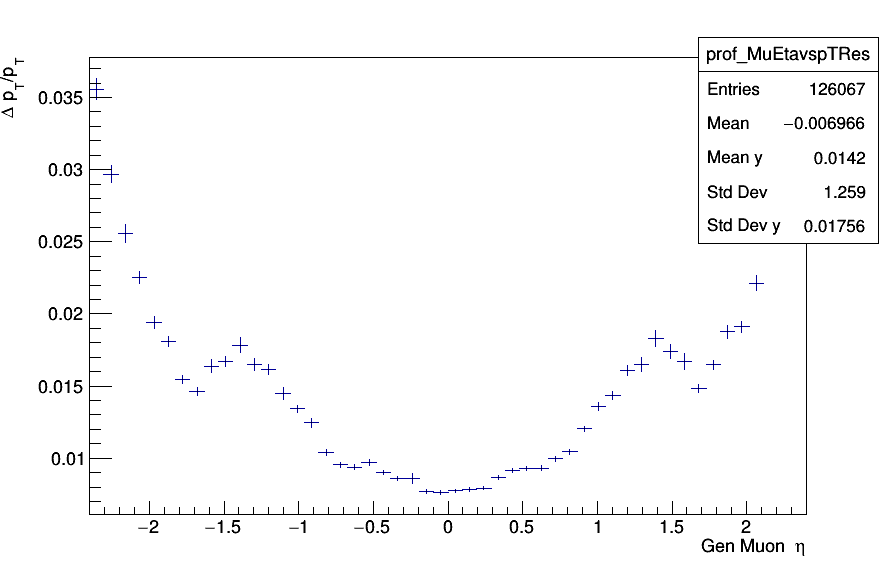

In [161]:
prof_MuEtavspTRes = ROOT.TProfile("prof_MuEtavspTRes",";Gen Muon #eta;#Delta p_{T}/p_{T}",50,-2.4,2.4,0,1)
for ptres, eta in zip(pt_res, two_gen_muon_p4.eta.flatten()):
    prof_MuEtavspTRes.Fill(eta, ptres, 1)
c7 = ROOT.TCanvas("muetavsptres","",900,600)
prof_MuEtavspTRes.Draw()
c7.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: prof_MupTvspTRes (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: muptvsptres


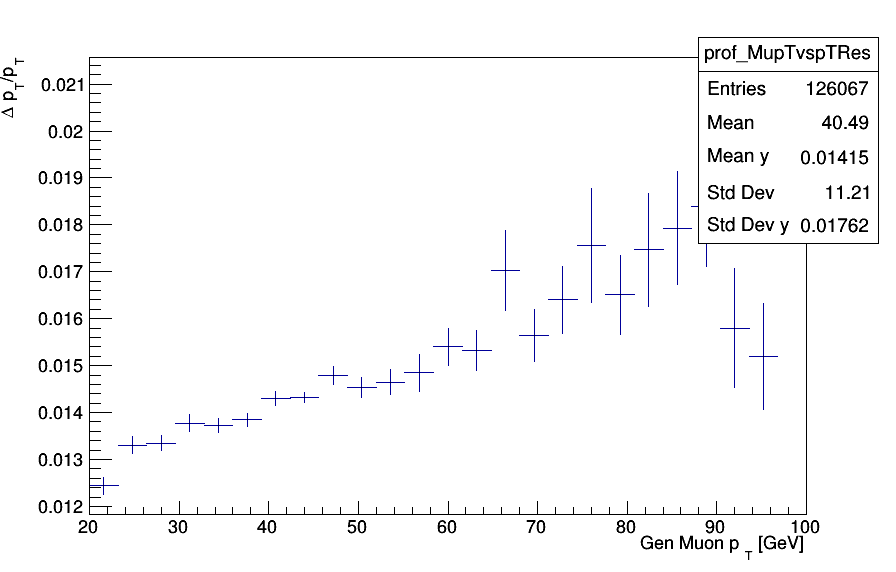

In [162]:
prof_MupTvspTRes = ROOT.TProfile("prof_MupTvspTRes",";Gen Muon p_{T} [GeV];#Delta p_{T}/p_{T}",25,20,100,0,1)
for ptres, pt in zip(pt_res, two_gen_muon_p4.pt.flatten()):
    prof_MupTvspTRes.Fill(pt, ptres, 1)
c8 = ROOT.TCanvas("muptvsptres","",900,600)
prof_MupTvspTRes.Draw()
c8.Draw()

**Questions 3**:
* What is the typical 1/pT resolution of a 50 GeV muon measured in the CMS detector?
* How does the 1/pT resolution scale with transverse momentum? And with the pseudorapidity?
* Why is the mass residual not a perfect Gaussian distribution?
* How is the 1/pT resolution related to the invariant mass resolution?

# Step 4: Momentum scale corrections

In [174]:
rc=roccor.RoccoR('RoccoR2018.txt')

In [168]:
random=np.random.rand(len(muon.muon_eta.flatten()))

In [175]:
rc.kScaleFromGenMC(muon.muon_charge.flatten(), muon.muon_pt.flatten(), muon.muon_eta.flatten(), muon.muon_phi.flatten(), muon.muon_ntrackerlayers.flatten(), muon.genpart_pt.flatten(), random, 0,0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [170]:
a.kScaleFromGenMC(1,2,3,3,5,6,6,65,0)

IndexError: list index out of range

In [176]:
two_opposite_good_muons

<JaggedArray [[<Row 2> <Row 3>] [<Row 9> <Row 10>] [<Row 14> <Row 15>] ... [<Row 436140> <Row 436141>] [<Row 436145> <Row 436146>] [<Row 436148> <Row 436149>]] at 0x7fb5393dd110>